In [1]:
import os
import os.path
from os import walk
from os.path import join
import numpy as np

base_path = '/atlas/home/zwpeng/paper_rebuild/camelyon/'

def get_picture(path):
    path0 = join(base_path + path)
    picture = []
    for _,_,filenames in walk(path0):
        for filename in filenames:
            file_prefix = os.path.splitext(filename)[0]
            if os.path.exists(join(path0, file_prefix + ".tif")):
                picture.append(filename)
            else:
                print("路径不对或者没有这种格式的文件")
    return picture

In [2]:
# 训练集、验证集、测试集严密隔离

train_set = get_picture("train/tumor/origin_images/")    # 训练集数据文件夹
valid_set = get_picture("validation/")    # 验证集数据文件夹
test_set = get_picture("test/")    # 测试集数据文件夹

# mask_pictures = get_picture("train/tumor/annotation_images/")    # 所有的mask图文件夹

# print(len(train_set), len(valid_set), len(mask_pictures))
# print("训练数据集是：\n",train_set)
# print("验证数据集是：\n",valid_set)
print("测试数据集是：\n",test_set)

# print("所有数据对应的mask图是：\n",mask_pictures)

测试数据集是：
 ['Tumor_001.tif', 'Tumor_003.tif']


In [3]:
import openslide

def path_to_slide(random_choice):
    random_choice_path = join(base_path, "train/tumor/origin_images/" + random_choice)
    random_mask_path = join(base_path, "train/tumor/annotation_images/" + (random_choice.split("."))[0] + "_Mask.tif")
#     print("随机选取一张训练集图的路径是：", random_choice_path)
#     print("该图片对应的mask路径是：", random_mask_path)
    origin_slide = openslide.open_slide(random_choice_path)
    mask_slide = openslide.open_slide(random_mask_path)
    return origin_slide, mask_slide

def path_to_slide_valid(random_choice):
    random_choice_path = join(base_path, "validation/" + random_choice)
    random_mask_path = join(base_path, "train/tumor/annotation_images/" + (random_choice.split("."))[0] + "_Mask.tif")
#     print("随机选取一张验证集的路径是：", random_choice_path)
#     print("该图片对应的mask路径是：", random_mask_path)
    origin_slide = openslide.open_slide(random_choice_path)
    mask_slide = openslide.open_slide(random_mask_path)
    return origin_slide, mask_slide

def path_to_slide_test(random_choice):
    random_choice_path = join(base_path, "test/" + random_choice)
    random_mask_path = join(base_path, "train/tumor/annotation_images/" + (random_choice.split("."))[0] + "_Mask.tif")
#     print("随机选取一张测试集的路径是：", random_choice_path)
#     print("该图片对应的mask路径是：", random_mask_path)
    origin_slide = openslide.open_slide(random_choice_path)
    mask_slide = openslide.open_slide(random_mask_path)
    return origin_slide, mask_slide

In [4]:
from pylab import *
import numpy as np

# 感兴趣区域锁定函数
def locate_ROI(origin_slide,level=6):
    origin_widths,origin_heights = origin_slide.dimensions

    object_widths,object_heights = origin_slide.level_dimensions[level]

    rgb_list_y = list()
    rgb_list_x = list()
    rgb_var_x = []
    rgb_var_y = []
    rgb_var_xi = []
    rgb_var_yi = []

    # 寻找有效区域的y值、高度
    for k in range(100):
        slide = origin_slide.read_region((0, k*origin_heights//100), level, (object_widths, object_heights//50)) 
        slide_arr = array(slide.convert("RGB"))
        arrR = np.mean(slide_arr[:,:,:1])
        arrG = np.mean(slide_arr[:,:,1:2])
        arrB = np.mean(slide_arr[:,:,2:3])
        rgb_list_y.append((arrR,arrG,arrB))
    for i,rgbVar in enumerate(rgb_list_y):
        rgb_var_y.append(np.var(rgbVar))
        if np.var(rgbVar)>=1:
            rgb_var_yi.append(i)

    effective_y = min(rgb_var_yi)*origin_heights//100        #有效区域的左上顶点y坐标找到了
    effective_heights = (max(rgb_var_yi)-min(rgb_var_yi))*origin_heights//100 + origin_heights//50  #有效区域的高度也出来了
#     print("有效区域的ｙ值是：%d" %effective_y, "有效区域的高度是：%d" %effective_heights)

    # 寻找有效区域的x值、宽度
    for j in range(100):
        slide = origin_slide.read_region((j*origin_widths//100, effective_y), level, 
                                          (object_widths//50, effective_heights//62))     # 循环顺序读取50宽的区域

        slide_arr = array(slide.convert("RGB"))
        arrR = np.mean(slide_arr[:,:,:1])
        arrG = np.mean(slide_arr[:,:,1:2])
        arrB = np.mean(slide_arr[:,:,2:3])
        rgb_list_x.append((arrR,arrG,arrB))
    for i,rgbVar in enumerate(rgb_list_x):
        rgb_var_x.append(np.var(rgbVar))
        if np.var(rgbVar)>=2:
            rgb_var_xi.append(i)

    effective_x = min(rgb_var_xi)*origin_widths//100        # 有效区域的左上顶点y坐标找到了
    effective_widths = (max(rgb_var_xi) - min(rgb_var_xi))*origin_widths//100 + origin_widths//50  # 有效区域的宽度也出来了
    return effective_x,effective_y,effective_widths,effective_heights

In [5]:
from pylab import *
import numpy as np

def locate_ROI_mask(mask_slide,mask_level=7):
    # level0　的尺寸
    mask_widths, mask_heights = mask_slide.dimensions
    # level7 的尺寸
    mask_level_widths, mask_level_heights = mask_slide.level_dimensions[mask_level]

    mask_level_slide = mask_slide.read_region((0, 0), mask_level, (mask_level_widths, mask_level_heights))
    mask_level_slide_gray = mask_level_slide.convert("L")
    mask_level_slide_arr = array(mask_level_slide_gray)

    mask_y, mask_x = nonzero(mask_level_slide_arr)  # 因为mask是黑白图，只需直接获得非零像素的坐标
    # mask_x, mask_y
    tumor_leftup_x = (min(mask_x)-1) * int(mask_slide.level_downsamples[mask_level])
    tumor_leftup_y = (min(mask_y)-1) * int(mask_slide.level_downsamples[mask_level])
    tumor_rightdown_x = (max(mask_x)+1) * int(mask_slide.level_downsamples[mask_level])
    tumor_rightdown_y = (max(mask_y)+1) * int(mask_slide.level_downsamples[mask_level])
    
#     print(tumor_leftup_x,tumor_leftup_y,tumor_rightdown_x,tumor_rightdown_y)
    mask_effective_widths = tumor_rightdown_x - tumor_leftup_x
    mask_effective_heights = tumor_rightdown_y - tumor_leftup_y
    
#     mask_tumor_area = ((max(mask_x)-min(mask_x)+2)*int(mask_slide.level_downsamples[mask_level]), 
#                        (max(mask_y)-min(mask_y)+2)*int(mask_slide.level_downsamples[mask_level]))
#     print(mask_tumor_area)        # mask区域的长宽
    return tumor_leftup_x,tumor_leftup_y,mask_effective_widths,mask_effective_heights

In [6]:
def effective_list(data_set):
    random_set = {}
#     random_choice = np.random.choice(data_set)    # 随机从数据集列表中选取一张图片路径
    for i in range(len(data_set)):
        if data_set == train_set:
            origin_slide, mask_slide = path_to_slide(data_set[i])
        elif data_set == valid_set:
            origin_slide, mask_slide = path_to_slide_valid(data_set[i])
        elif data_set == test_set:
            origin_slide, mask_slide = path_to_slide_test(data_set[i])
        else:
            print("数据集加载不正确")

        try:
            [[effective_x,effective_y,effective_widths,effective_heights],
             [tumor_leftup_x,tumor_leftup_y,mask_effective_widths,mask_effective_heights]] = random_set[data_set[i]]
        except KeyError:
            effective_x,effective_y,effective_widths,effective_heights = locate_ROI(origin_slide)            
            tumor_leftup_x,tumor_leftup_y,mask_effective_widths,mask_effective_heights = locate_ROI_mask(mask_slide)
            random_set[data_set[i]] = [[effective_x,effective_y,effective_widths,effective_heights],
                                         [tumor_leftup_x,tumor_leftup_y,mask_effective_widths,mask_effective_heights]]
    return random_set

In [7]:
import time
start_time = time.clock()

# eff_train = effective_list(train_set)    # 所有训练数据的有效区域　存放字典
# eff_valid = effective_list(valid_set)    # 所有验证数据的有效区域　存放字典
eff_test = effective_list(test_set)    # 所有测试数据的有效区域　存放字典
# print(len(eff_train),len(eff_valid),len(eff_test))
# print(eff_train, '\n')
# print(eff_valid, '\n')
print(eff_test, '\n')

end_time = time.clock()
print('本段代码执行时间是：%s'%(end_time-start_time))

{'Tumor_001.tif': [[977, 59719, 74321, 99532], [69888, 122496, 3456, 12160]], 'Tumor_003.tif': [[25425, 103956, 69431, 70778], [73728, 146688, 7424, 7296]]} 

本段代码执行时间是：6.166974000000001


25425 103956 69431 70778 73728 146688 7424 7296


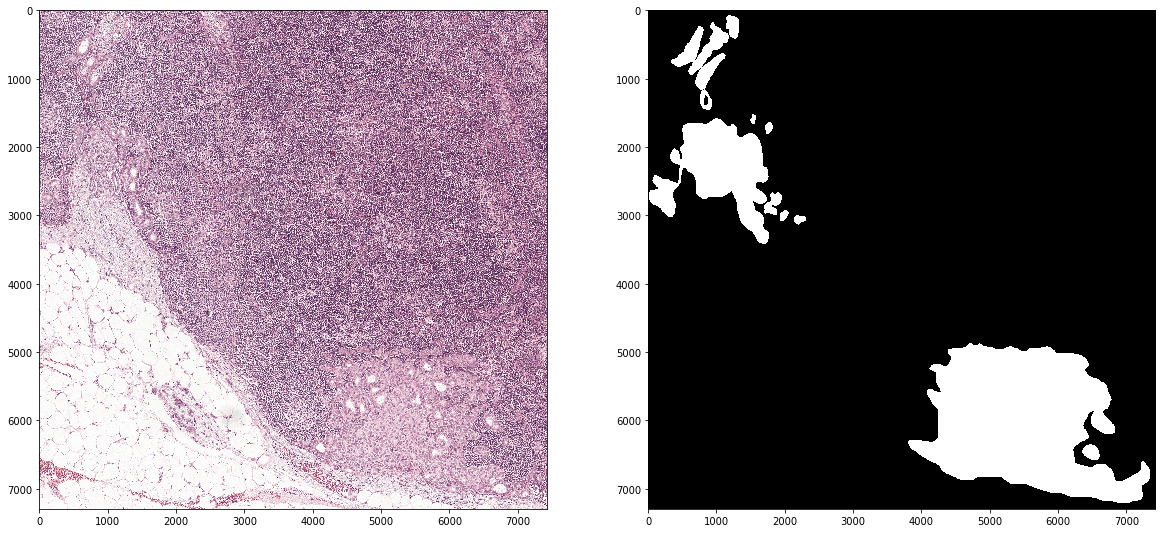

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline


s_image_003, m_image_003 = path_to_slide_test('Tumor_003.tif')
[[effective_x,effective_y,effective_widths,effective_heights],
 [tumor_leftup_x,tumor_leftup_y,mask_effective_widths,mask_effective_heights]] = eff_test['Tumor_003.tif']

print(effective_x,effective_y,effective_widths,effective_heights,tumor_leftup_x,tumor_leftup_y,mask_effective_widths,mask_effective_heights)


s_image_003 = s_image_003.read_region((tumor_leftup_x,tumor_leftup_y),0,(mask_effective_widths,mask_effective_heights))
m_image_003 = m_image_003.read_region((tumor_leftup_x,tumor_leftup_y),0,(mask_effective_widths,mask_effective_heights))

f, axes = plt.subplots(1,2,figsize=(20,20))
ax = axes.flatten()
_=ax[0].imshow(s_image_003)
_=ax[1].imshow(m_image_003)

In [9]:
def prediction_from_model(patch, model):    
    prediction = model.predict(patch.reshape(1, 299, 299, 3))
    return prediction

In [10]:
# 步长设置为128,试一下预测效果

from keras.models import load_model
from PIL import Image
import time

start_time = time.clock()

model = load_model('model_1000_8_04.h5')
# model = load_model('../../model_0823.h5')
step_len = 128
widths, heights = 299, 299

# s_image_005 = Image.open('s_image_003.jpg')

imgs_128 = np.zeros((1, s_image_003.size[0]//step_len+1))

for i in range(s_image_003.size[1]//step_len):
    imgs_128_1 = np.zeros((1, 1))
    
    for j in range(s_image_003.size[0]//step_len):
        pat = s_image_003.crop((j*step_len,i*step_len,j*step_len+widths,i*step_len+heights))
        pat_array = np.array(pat.convert("RGB"))/255.
        pre_pat = prediction_from_model(pat_array, model)
        imgs_128_1 = np.hstack((imgs_128_1, np.ones((1, 1))*(pre_pat[0][1])))
    imgs_128 = np.vstack((imgs_128, imgs_128_1))

end_time = time.clock()

print(imgs_128.shape)
print(end_time-start_time)

Using TensorFlow backend.


(58, 59)
300.727276


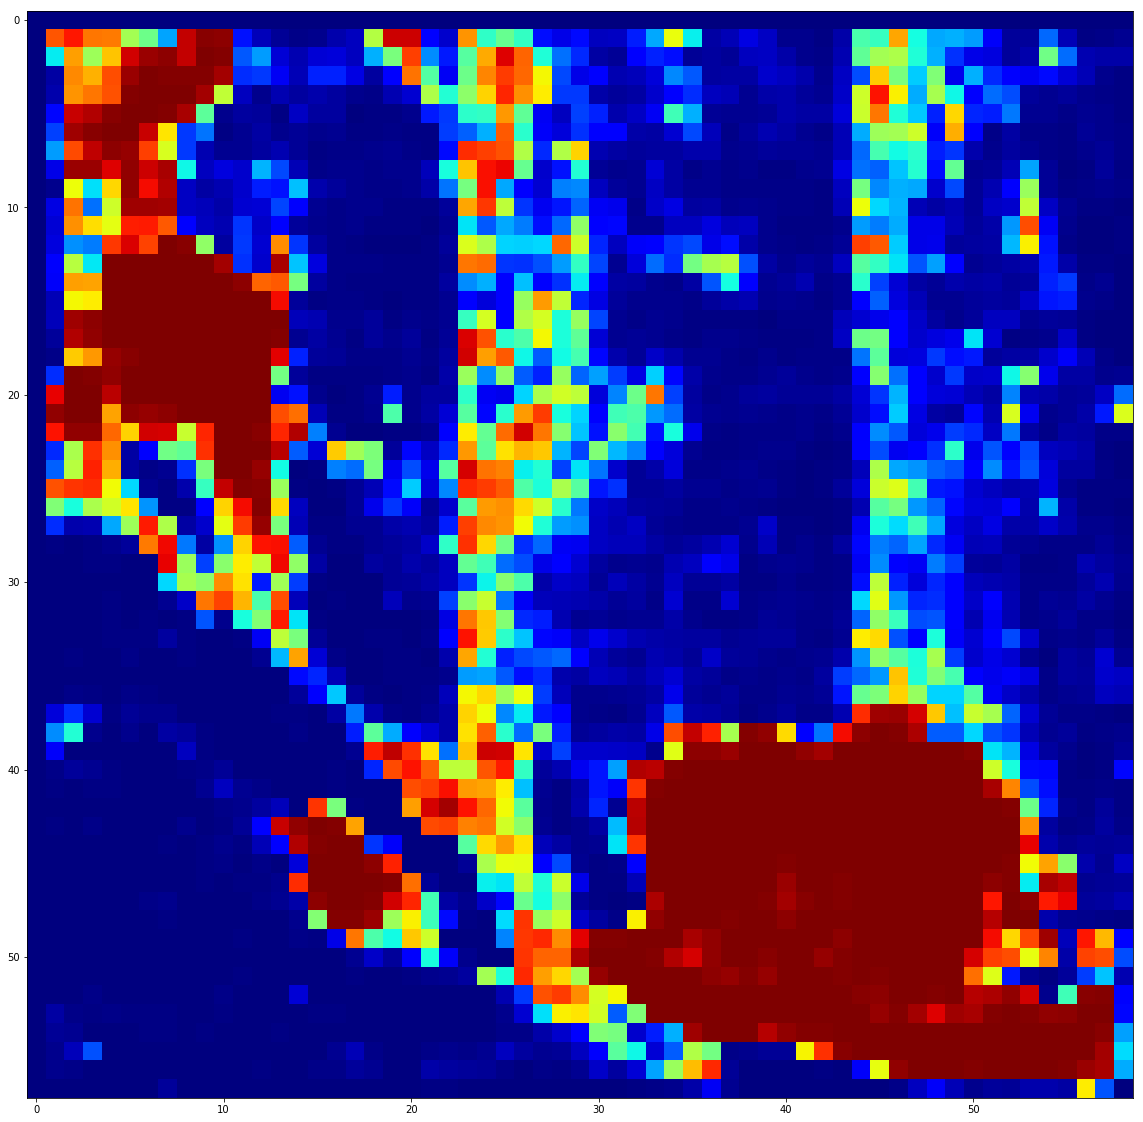

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(imgs_128, cmap='jet', vmin=0, vmax=1)


In [15]:
# 步长设置为128,试一下预测效果

from keras.models import load_model
from PIL import Image
import time

start_time = time.clock()

# model = load_model('model_1000_8_04.h5')
# model = load_model('../../model_0823.h5')
step_len = 128
widths, heights = 299, 299

# s_image_005 = Image.open('s_image_003.jpg')

imgs_128 = np.zeros((1, s_image_003.size[0]//step_len+1))

for i in range(s_image_003.size[1]//step_len):
    imgs_128_1 = np.zeros((1, 1))
    
    for j in range(s_image_003.size[0]//step_len):
        pat = s_image_003.crop((j*step_len,i*step_len,j*step_len+widths,i*step_len+heights))
        pat_array = np.array(pat.convert("RGB"))/255.
        pre_pat = prediction_from_model(pat_array, model)
        imgs_128_1 = np.hstack((imgs_128_1, np.ones((1, 1))*(pre_pat[0][1])))
    imgs_128 = np.vstack((imgs_128, imgs_128_1))

end_time = time.clock()

print(imgs_128.shape)
print(end_time-start_time)

(58, 59)
279.8131650000001


In [16]:
# 步长设置为64,试一下预测效果

from keras.models import load_model
from PIL import Image
import time

start_time = time.clock()

# model = load_model('model_1000_8_04.h5')
# model = load_model('../../model_0823.h5')
step_len = 64
widths, heights = 299, 299

# s_image_005 = Image.open('s_image_003.jpg')

imgs_64 = np.zeros((1, s_image_003.size[0]//step_len+1))

for i in range(s_image_003.size[1]//step_len):
    imgs_64_1 = np.zeros((1, 1))
    
    for j in range(s_image_003.size[0]//step_len):
        pat = s_image_003.crop((j*step_len,i*step_len,j*step_len+widths,i*step_len+heights))
        pat_array = np.array(pat.convert("RGB"))/255.
        pre_pat = prediction_from_model(pat_array, model)
        imgs_64_1 = np.hstack((imgs_64_1, np.ones((1, 1))*(pre_pat[0][1])))
    imgs_64 = np.vstack((imgs_64, imgs_64_1))

end_time = time.clock()

print(imgs_64.shape)
print(end_time-start_time)

(115, 117)
1123.03288


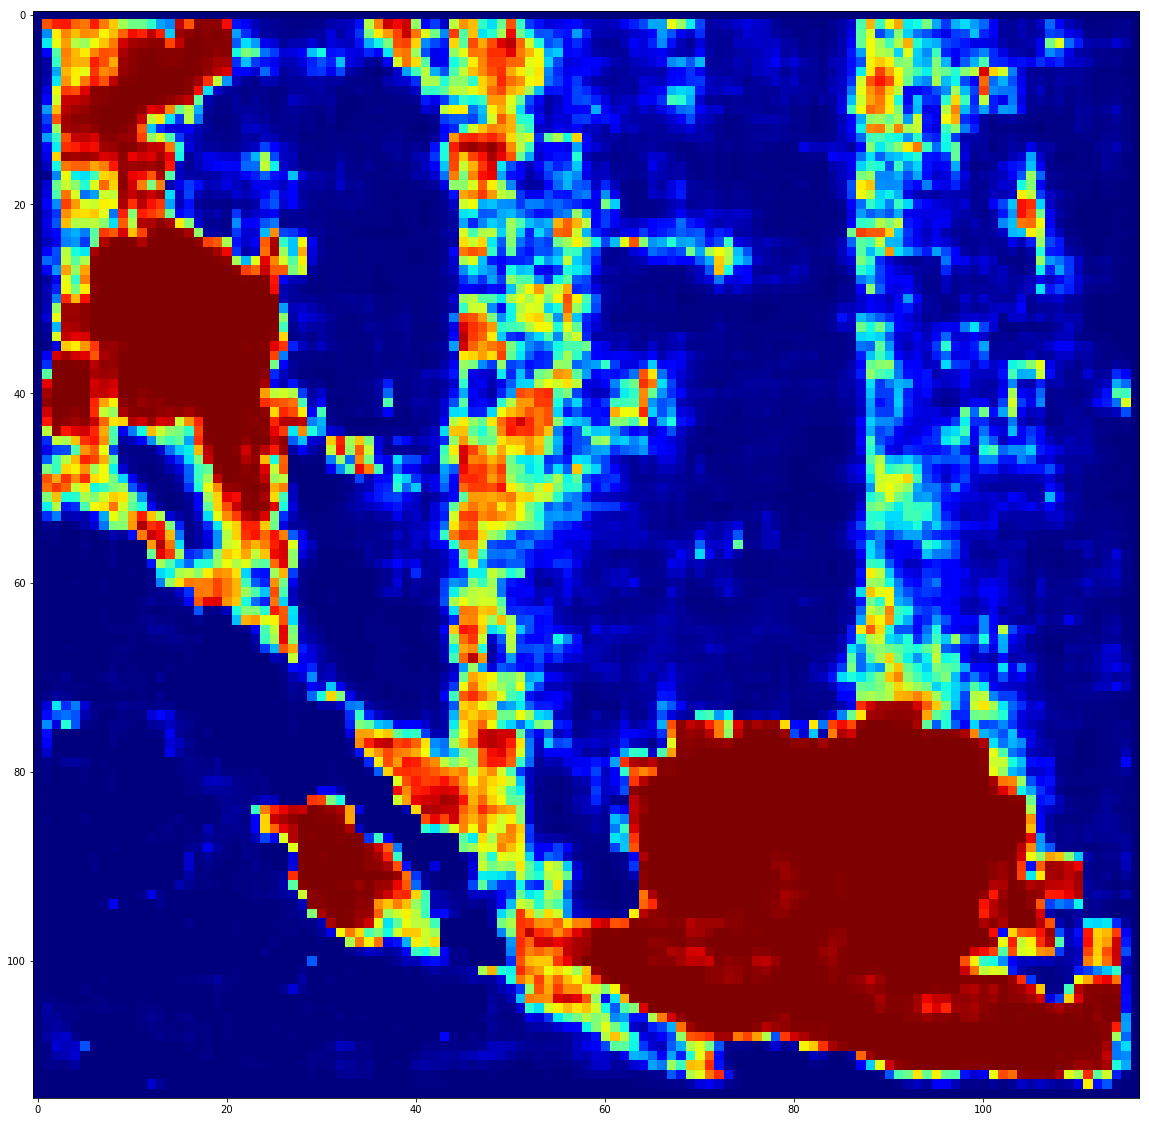

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(imgs_64, cmap='jet', vmin=0, vmax=1)


(229, 233)
4514.827936


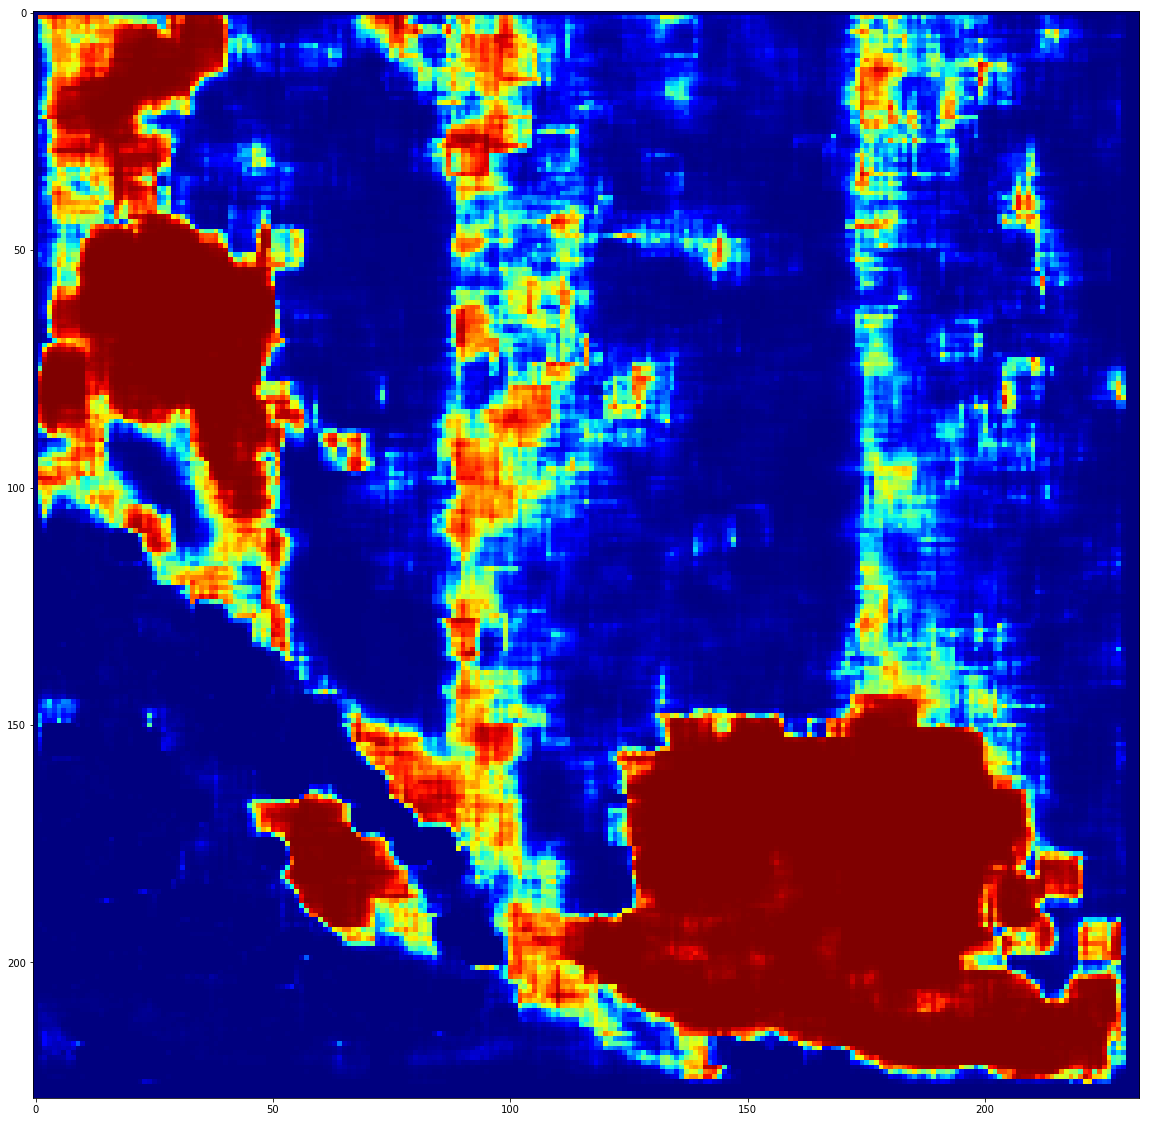

In [19]:
# 步长设置为32,试一下预测效果

from keras.models import load_model
from PIL import Image
import time

start_time = time.clock()

# model = load_model('model_1000_8_04.h5')
# model = load_model('../../model_0823.h5')
step_len = 32
widths, heights = 299, 299

# s_image_005 = Image.open('s_image_003.jpg')

imgs_32 = np.zeros((1, s_image_003.size[0]//step_len+1))

for i in range(s_image_003.size[1]//step_len):
    imgs_32_1 = np.zeros((1, 1))
    
    for j in range(s_image_003.size[0]//step_len):
        pat = s_image_003.crop((j*step_len,i*step_len,j*step_len+widths,i*step_len+heights))
        pat_array = np.array(pat.convert("RGB"))/255.
        pre_pat = prediction_from_model(pat_array, model)
        imgs_32_1 = np.hstack((imgs_32_1, np.ones((1, 1))*(pre_pat[0][1])))
    imgs_32 = np.vstack((imgs_32, imgs_32_1))

end_time = time.clock()

print(imgs_32.shape)
print(end_time-start_time)

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(imgs_32, cmap='jet', vmin=0, vmax=1)

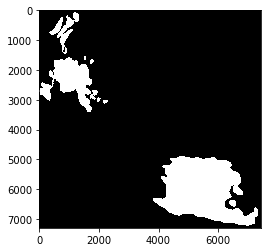

In [81]:
%matplotlib inline
plt.imshow(m_image_003)
plt.show()

In [96]:
m_image_003.mode

m_image_003.save('mask_003.jpg')

In [99]:
from PIL import Image
import time

start_time = time.clock()

# model = load_model('model_1000_8_04.h5')
# model = load_model('../../model_0823.h5')
step_len = 32
widths, heights = 299, 299


y = []
for i in range(s_image_003.size[1]//step_len):
    for j in range(s_image_003.size[0]//step_len):
        mask_pat = m_image_003.crop((j*step_len,i*step_len,j*step_len+widths,i*step_len+heights))
        mask_pat_array = np.array(mask_pat.convert("L"))
        if mask_pat_array.any()!= 0:
            y.append(1)
        else:
            y.append(0)

end_time = time.clock()
print(end_time-start_time)

16.854510999999547


In [54]:
print(len(y), y[:10])

52896 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [37]:
imgs_32_s = imgs_32

In [41]:
imgs_32_s = np.delete(imgs_32_s,0,1)
imgs_32_s.shape

(229, 232)

In [42]:
imgs_32_s = np.delete(imgs_32_s,0,0)
imgs_32_s.shape

(228, 232)

In [101]:
y = np.array(y)
y[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [102]:
y.mean()

0.21746445856019359

In [68]:
pred = imgs_32_s.reshape(52896)

In [69]:
print(type(y), type(pred))
print(y.shape, pred.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(52896,) (52896,)


In [103]:
print(y[50:100])
print(pred[50:100])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0.01304722  0.01339692  0.00907299  0.01054724  0.01117706  0.01336229
  0.01321724  0.0127087   0.01666688  0.02558105  0.03983768  0.032245
  0.04724151  0.05147387  0.05813184  0.07898469  0.13995627  0.28852907
  0.56855893  0.72500521  0.77066994  0.91931885  0.9330644   0.93021697
  0.9012472   0.97842693  0.93177986  0.81897038  0.5294798   0.3104164
  0.11891396  0.11013414  0.1804041   0.10892873  0.06830554  0.23598439
  0.57938737  0.39187536  0.75361139  0.79287845  0.70978642  0.68976378
  0.40958771  0.46129328  0.34598985  0.27890998  0.47301322  0.7765528
  0.82321852  0.7231617 ]


AUC:0.930788161319


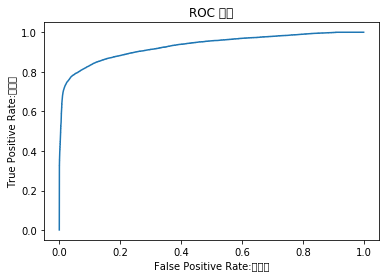

In [118]:
from sklearn import metrics
import matplotlib.pyplot as plt 
%matplotlib inline

fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=None)

print('AUC:%s'%(metrics.auc(fpr, tpr)))

plt.title('ROC 曲线')
plt.xlabel('False Positive Rate:误判率')
plt.ylabel('True Positive Rate:正确率')
plt.plot(fpr, tpr)
plt.show()

AUC:0.930788161319


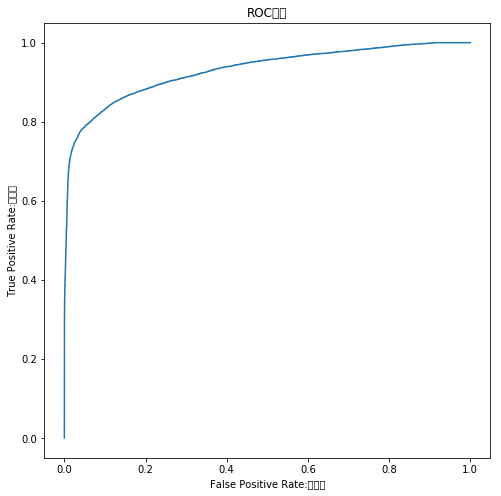

In [122]:
from sklearn import metrics
import matplotlib.pyplot as plt 
%matplotlib inline

fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=None)

print('AUC:%s'%(metrics.auc(fpr, tpr)))

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fpr, tpr)
ax.set_xlabel('False Positive Rate:误判率')
ax.set_ylabel('True Positive Rate:正确率')
ax.set_title('ROC曲线')

In [127]:
fpr.shape[0]

7652

AUC:0.930788161319


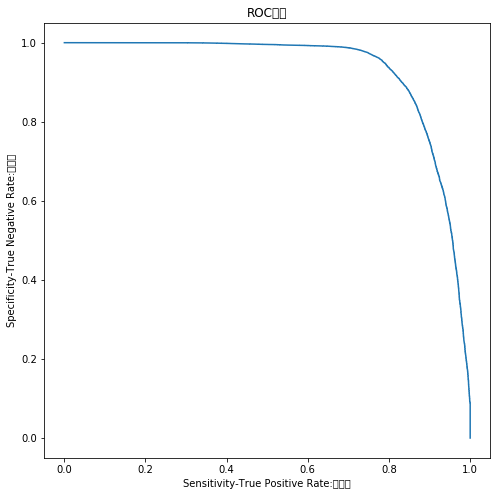

In [130]:
from sklearn import metrics
import matplotlib.pyplot as plt 
%matplotlib inline

fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=None)

print('AUC:%s'%(metrics.auc(fpr, tpr)))

speci = []

for i in range(fpr.shape[0]):
    speci.append(1-fpr[i])

speci = np.array(speci)

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(tpr, speci)
ax.set_xlabel('Sensitivity-True Positive Rate:正确率')
ax.set_ylabel('Specificity-True Negative Rate:误判率')
ax.set_title('ROC曲线')

AUC:0.930788161319


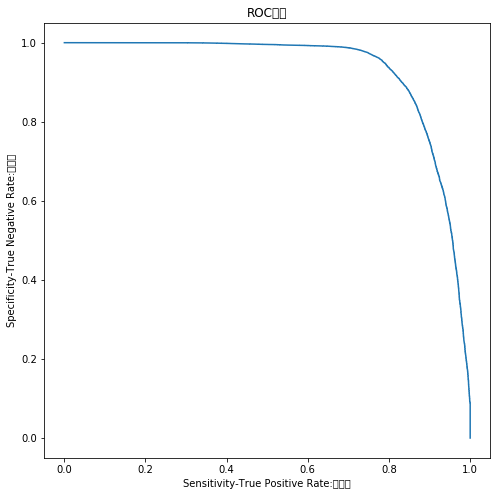

In [132]:
from sklearn import metrics
import matplotlib.pyplot as plt 
%matplotlib inline

fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=None)

print('AUC:%s'%(metrics.auc(fpr, tpr)))

# speci = []

# for i in range(fpr.shape[0]):
#     speci.append(1-fpr[i])

# speci = np.array(speci)

fig, ax = plt.subplots(figsize=(8, 8))
# ax.plot(tpr, speci)

ax.plot(tpr, [(1-fpr[i]) for i in range(fpr.shape[0])])    # 一句循环获取该array

ax.set_xlabel('Sensitivity-True Positive Rate:正确率')
ax.set_ylabel('Specificity-True Negative Rate:误判率')
ax.set_title('ROC曲线')